<a href="https://colab.research.google.com/github/a-tuck-ai/AEI4/blob/main/Anna_Tucker_Prototyping_LangChain_Application_with_Production_Minded_Changes_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - df5c2c3c


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving twilight-2008.pdf to twilight-2008 (1).pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'twilight-2008 (1).pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

Cache-backed embeddings can speed up repeated queries and batch processing by avoiding redundant API calls, but they come with increased storage requirements and potential consistency issues across different environments. The approach is most beneficial for applications with frequent, similar queries or during development and testing phases. However, it may be less advantageous for highly dynamic content, one-time operations, or memory-constrained environments. The effectiveness of this method ultimately depends on the specific use case, with factors like query patterns, data volatility, and system resources playing crucial roles in determining its utility.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [10]:
import time

# Embedding/Time
def run_cache_test(query):
    start_time = time.time()
    _ = retriever.invoke(query)
    end_time = time.time()
    return end_time - start_time

# Test text
test_text = "What did Edward call Bella when he climbed trees with her on her back?"

# First run (without cache)
first_run_time = run_cache_test(test_text)
print(f"First run time (without cache): {first_run_time:.4f} seconds")

# Second run (with cache)
second_run_time = run_cache_test(test_text)
print(f"Second run time (with cache): {second_run_time:.4f} seconds")

# Calculate and print the speedup
speedup = (first_run_time - second_run_time) / first_run_time * 100
print(f"Speedup: {speedup:.2f}%")

First run time (without cache): 0.4756 seconds
Second run time (with cache): 0.3026 seconds
Speedup: 36.37%


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [12]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [13]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

 This approach has limitations, including potential data staleness, reduced personalization, and challenges with context sensitivity, making it less suitable for highly dynamic content, creative tasks, or security-sensitive applications. The effectiveness of prompt caching ultimately depends on the specific use case, balancing the trade-offs between performance gains and potential drawbacks in accuracy or relevance.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [14]:
def run_llm_test(prompt):
    start_time = time.time()
    response = chat_model.invoke(prompt)
    end_time = time.time()
    return end_time - start_time, response

# Test prompt
test_prompt = "What did Edward call Bella when he climbed trees with her on her back?"

# First run (without cache)
first_run_time, first_response = run_llm_test(test_prompt)
print(f"First run time (without cache): {first_run_time:.4f} seconds")
print(f"First response: {first_response.content[:50]}...")  # Print first 50 characters

# Second run (with cache)
second_run_time, second_response = run_llm_test(test_prompt)
print(f"\nSecond run time (with cache): {second_run_time:.4f} seconds")
print(f"Second response: {second_response.content[:50]}...")  # Print first 50 characters

# Calculate and print the speedup
speedup = (first_run_time - second_run_time) / first_run_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

# Verify cache is working
print(f"\nResponses identical: {first_response.content == second_response.content}")

# Test with a slightly different prompt
slightly_different_prompt = "What did Edward say to Bella when they climbed trees with her on his back??"
third_run_time, third_response = run_llm_test(slightly_different_prompt)
print(f"\nThird run time (different prompt): {third_run_time:.4f} seconds")
print(f"Third response: {third_response.content[:50]}...")

First run time (without cache): 1.3644 seconds
First response: In "Twilight," when Edward climbs trees with Bella...

Second run time (with cache): 0.0016 seconds
Second response: In "Twilight," when Edward climbs trees with Bella...

Speedup: 99.88%

Responses identical: True

Third run time (different prompt): 2.4150 seconds
Third response: In "Twilight," during the scene where Edward takes...


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [15]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [16]:
retrieval_augmented_qa_chain.invoke({"question" : "What did Edward call Bella when he climbed trees with her on her back?"})

AIMessage(content='Edward called Bella "Hold on" when he scooped her up onto his back as they climbed trees together.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1344, 'total_tokens': 1366, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_74ba47b4ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-2880b64f-cd84-409a-9a60-60e8a5e83162-0', usage_metadata={'input_tokens': 1344, 'output_tokens': 22, 'total_tokens': 1366})

Well I was trying to get "Spider Monkey" but it seems that was an improv line by Robert. Genius.

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

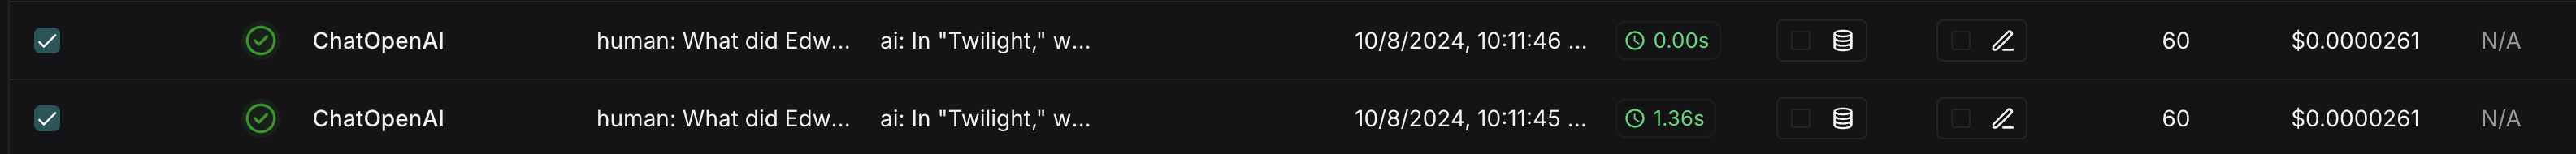